Training from several snapshots of data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [4]:
sla_summer[0] #some of the pressure terms are basically 0...

array([3.2483165e+08, 4.1973315e+08, 4.1957971e+08, 4.1792554e+08,
       4.1608573e+08, 4.1529331e+08, 4.1917523e+08, 4.2553757e+08,
       4.2796963e+08, 4.2935677e+08, 4.3002480e+08, 4.3050189e+08,
       4.2917203e+08, 4.2745120e+08, 4.2514688e+08, 4.2291594e+08,
       4.1778349e+08, 4.1280435e+08, 4.0147472e+08, 3.9112733e+08,
       3.8413638e+08, 3.7656957e+08, 3.6903552e+08, 3.6089472e+08,
       3.4957466e+08, 3.3627162e+08, 3.2291926e+08, 3.1016934e+08,
       2.9839315e+08, 2.8756467e+08, 2.7648986e+08, 2.6690755e+08,
       2.5770624e+08, 2.4404589e+08, 2.3087686e+08, 2.2010757e+08,
       2.1086104e+08, 2.0501749e+08, 2.0513592e+08, 1.9989923e+08,
       1.9729146e+08, 2.0554002e+08, 2.1805370e+08, 2.2201814e+08,
       2.1955205e+08, 2.1646682e+08, 2.2063669e+08, 2.3553512e+08,
       2.5117816e+08, 2.5322378e+08, 2.4153790e+08, 2.2494416e+08,
       1.9879157e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [5]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [6]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [7]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [123]:
sla_test_set, uif_test_set = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [9]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [10]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [11]:
from sklearn.model_selection import train_test_split
sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.9, random_state=42)

In [12]:
uif_train.shape

(227059, 52)

# Predicting Summer:

In [13]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(sla_train,uif_train)
uif_lin = lr1.predict(sla_summer)  
uif_out = uif_summer

In [14]:
lr1.coef_

array([[ 3.41186990e-08,  3.08322718e-08, -1.59478830e-08, ...,
         8.24838992e-07, -1.06795346e-06,  4.91201172e-06],
       [ 3.41186848e-08,  3.08322754e-08, -1.59476929e-08, ...,
         8.24828476e-07, -1.06795949e-06,  4.91196442e-06],
       [ 3.41186848e-08,  3.08322541e-08, -1.59477747e-08, ...,
         8.24823644e-07, -1.06796324e-06,  4.91191167e-06],
       ...,
       [ 3.94447106e-08,  3.03319965e-08, -1.38455603e-08, ...,
         6.11371263e-07, -6.48868081e-07,  2.01844932e-06],
       [ 3.97125675e-08,  3.08772350e-08, -1.39729819e-08, ...,
         6.13629254e-07, -6.49445838e-07,  1.96423071e-06],
       [ 4.00819644e-08,  3.17593845e-08, -1.38405465e-08, ...,
         6.18893296e-07, -6.51899086e-07,  1.89722937e-06]], dtype=float32)

In [15]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.879607

In [16]:
np.min(uif_out)

17.541994

In [17]:
np.max(uif_out)

339.41235

In [18]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

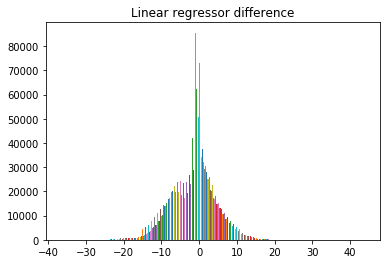

In [19]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [20]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [21]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

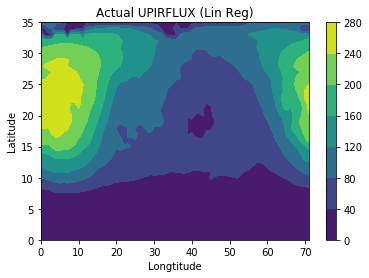

In [22]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

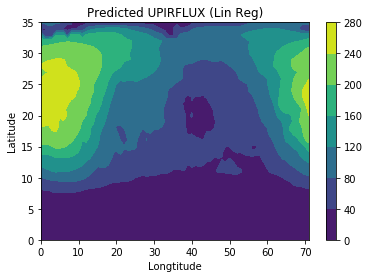

In [23]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

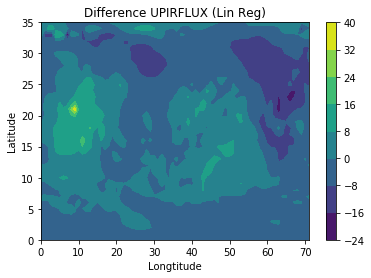

In [24]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

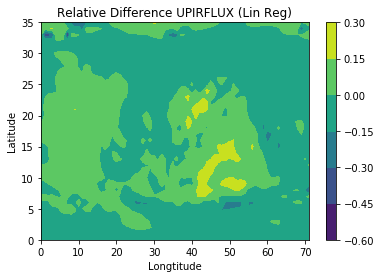

In [25]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [26]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [27]:
real_out.shape

(36, 72)

In [28]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [29]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.06402563, -0.02248735, -0.30331674, ..., -0.75554564,
        -0.2004167 , -0.22547271],
       [ 0.06406297, -0.02245   , -0.30330716, ..., -0.75552969,
        -0.20038362, -0.22543419],
       [ 0.06373025, -0.02275881, -0.30362737, ..., -0.75584747,
        -0.20070079, -0.22576334],
       ...,
       [-0.0692839 , -0.75201611, -0.48245375, ..., -0.9505221 ,
        -0.36618609, -0.98055978],
       [-0.06432426, -0.78224988, -0.49623214, ..., -0.95593665,
        -0.359093  , -1.00837541],
       [-0.0596745 , -0.82316435, -0.51699141, ..., -0.96133314,
        -0.35216627, -1.04597878]])

In [30]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.09797068,  0.09799806,  0.09768058,  0.09819143,  0.0979523 ,
        0.0979524 ,  0.09734762,  0.09786738,  0.09768887,  0.09741403,
        0.09772969,  0.09767955,  0.09766078,  0.09790219,  0.09791621,
        0.09767313,  0.09643964,  0.09371826,  0.08956661,  0.08280709,
        0.07293338,  0.05907777,  0.04277832,  0.02888417,  0.01827802,
        0.01224098,  0.00735001,  0.00620197,  0.00638085,  0.00572861,
        0.00196307, -0.00198066, -0.00961284, -0.02114888, -0.02699815,
       -0.02428547, -0.01479171, -0.00807779, -0.0026186 , -0.00100243,
       -0.00100774, -0.00353883, -0.00816449, -0.01245357, -0.01687923,
       -0.02098237, -0.02443433, -0.02552281, -0.0274482 , -0.0262308 ,
       -0.02106859, -0.01730558])

In [31]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.75573216, -0.75570439, -0.75602621, -0.75554615, -0.75588569,
       -0.75567655, -0.75602849, -0.7555528 , -0.75590942, -0.75631843,
       -0.75597551, -0.75587392, -0.7558558 , -0.75575193, -0.75586207,
       -0.75594561, -0.75661802, -0.75863299, -0.76258443, -0.76957987,
       -0.77932978, -0.7922527 , -0.80659235, -0.81865928, -0.82853816,
       -0.83463751, -0.84004885, -0.84263154, -0.84542518, -0.84956786,
       -0.85730511, -0.86684864, -0.88101506, -0.89366385, -0.89580613,
       -0.8939751 , -0.89278096, -0.89968082, -0.90690334, -0.92448725,
       -0.95245887, -0.97096077, -0.99050022, -1.0093026 , -1.02959809,
       -1.04583926, -1.06270789, -1.07944135, -1.10186194, -1.12775042,
       -1.1580564 , -1.19772709])

In [32]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.23982375, 0.23982644, 0.239826  , 0.23983786, 0.23986255,
       0.23977823, 0.23972926, 0.23975919, 0.2397917 , 0.23979199,
       0.23976722, 0.23973178, 0.23972638, 0.23976138, 0.23976829,
       0.23964515, 0.23939756, 0.23913676, 0.23900874, 0.23895575,
       0.23878148, 0.23816979, 0.23680735, 0.2350999 , 0.23358208,
       0.23220534, 0.23072353, 0.22912861, 0.22760316, 0.22589424,
       0.22414171, 0.22293108, 0.22210475, 0.219965  , 0.21748121,
       0.21773782, 0.22181497, 0.22995061, 0.23967557, 0.2444032 ,
       0.24956991, 0.25267965, 0.25573333, 0.25865417, 0.26162058,
       0.26390202, 0.26663612, 0.27008811, 0.27499217, 0.28206926,
       0.29197767, 0.3044529 ])

In [33]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.34675553, -0.34672595, -0.34704724, -0.34655301, -0.34684279,
       -0.3467656 , -0.3471872 , -0.34663672, -0.34688083, -0.34722353,
       -0.34689716, -0.34689037, -0.34688831, -0.34670927, -0.34673863,
       -0.34689256, -0.34785965, -0.35024943, -0.35437582, -0.36126413,
       -0.37091663, -0.38425108, -0.40003061, -0.41442526, -0.42701016,
       -0.43558038, -0.44310469, -0.44774404, -0.45219938, -0.45756428,
       -0.46620526, -0.47709644, -0.49397773, -0.51292502, -0.52565393,
       -0.53471098, -0.54293259, -0.55900027, -0.57673928, -0.58513626,
       -0.59519699, -0.60320584, -0.61248526, -0.62112601, -0.63076526,
       -0.63912944, -0.64714287, -0.65350177, -0.66335053, -0.67399278,
       -0.68486823, -0.70013276])

In [34]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.46529780279303656


# Predicting Fall:

In [35]:
uif_lin = lr1.predict(sla_fall) 
uif_out = uif_fall

In [36]:
lr1.coef_

array([[ 3.41186990e-08,  3.08322718e-08, -1.59478830e-08, ...,
         8.24838992e-07, -1.06795346e-06,  4.91201172e-06],
       [ 3.41186848e-08,  3.08322754e-08, -1.59476929e-08, ...,
         8.24828476e-07, -1.06795949e-06,  4.91196442e-06],
       [ 3.41186848e-08,  3.08322541e-08, -1.59477747e-08, ...,
         8.24823644e-07, -1.06796324e-06,  4.91191167e-06],
       ...,
       [ 3.94447106e-08,  3.03319965e-08, -1.38455603e-08, ...,
         6.11371263e-07, -6.48868081e-07,  2.01844932e-06],
       [ 3.97125675e-08,  3.08772350e-08, -1.39729819e-08, ...,
         6.13629254e-07, -6.49445838e-07,  1.96423071e-06],
       [ 4.00819644e-08,  3.17593845e-08, -1.38405465e-08, ...,
         6.18893296e-07, -6.51899086e-07,  1.89722937e-06]], dtype=float32)

In [37]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.0766892

In [38]:
np.min(uif_out)

15.713927

In [39]:
np.max(uif_out)

484.24545

In [40]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

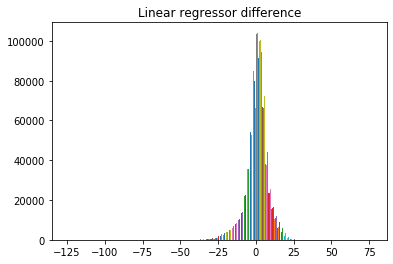

In [41]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [42]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [43]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

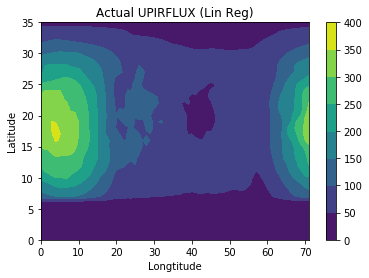

In [44]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

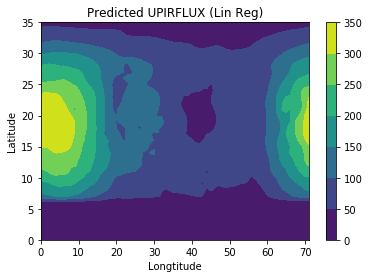

In [45]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

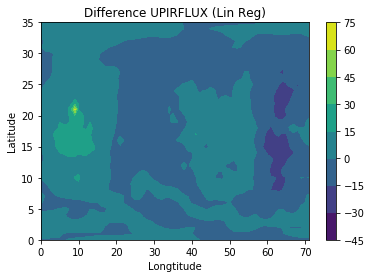

In [46]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

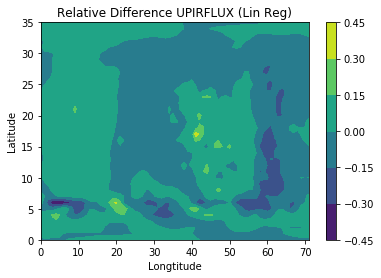

In [47]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [48]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [49]:
real_out.shape

(36, 72)

In [50]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [51]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.09742285, -0.39981061, -0.25725055, ..., -0.59937623,
         0.20241624,  0.15709355],
       [-0.09735877, -0.39976525, -0.25719716, ..., -0.59932748,
         0.20246854,  0.1571583 ],
       [-0.09767827, -0.40007149, -0.25751788, ..., -0.59965604,
         0.20215114,  0.15684645],
       ...,
       [-0.52189838, -1.39076069, -0.66679854, ..., -0.93072569,
         0.02211465, -0.58986535],
       [-0.4946257 , -1.40437378, -0.65553863, ..., -0.90717377,
         0.05105592, -0.60197823],
       [-0.45668616, -1.41977845, -0.64141287, ..., -0.87351897,
         0.08861991, -0.61762451]])

In [52]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.25132742,  0.25139003,  0.25106308,  0.25155762,  0.25120532,
        0.25136914,  0.25116052,  0.25197298,  0.25178814,  0.25108268,
        0.25107296,  0.25093655,  0.25068552,  0.2501908 ,  0.24941563,
        0.24835162,  0.24714632,  0.24593039,  0.24533979,  0.24579664,
        0.24785219,  0.25090758,  0.25324267,  0.2536274 ,  0.24882768,
        0.2405431 ,  0.22739518,  0.21085872,  0.18828485,  0.16116943,
        0.13115062,  0.10029068,  0.06154176,  0.01496859, -0.02435068,
       -0.0566439 , -0.07817481, -0.08577504, -0.07862713, -0.0724476 ,
       -0.06437434, -0.0597602 , -0.05508585, -0.04811059, -0.03949899,
       -0.0335517 , -0.02552379, -0.01256931,  0.00183457,  0.02211465,
        0.05105592,  0.08861991])

In [53]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-1.06689495, -1.06682456, -1.06715722, -1.06676149, -1.06708667,
       -1.06709789, -1.06765913, -1.06693443, -1.06682875, -1.06720782,
       -1.06701415, -1.06726521, -1.06771862, -1.06818942, -1.06871721,
       -1.06953222, -1.07090053, -1.07273263, -1.07448339, -1.07562244,
       -1.07505215, -1.07304667, -1.07135474, -1.07185044, -1.07766799,
       -1.08739221, -1.10242511, -1.1216648 , -1.14787248, -1.18116467,
       -1.21931135, -1.25969738, -1.30582489, -1.35568566, -1.39739279,
       -1.4410224 , -1.48717853, -1.52847842, -1.55354846, -1.55889092,
       -1.56211045, -1.56445335, -1.56698747, -1.56740086, -1.56671604,
       -1.56646671, -1.56409564, -1.55685148, -1.54900084, -1.53738528,
       -1.51803655, -1.48752132])

In [54]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.3479466 , 0.34794759, 0.34795433, 0.34800883, 0.34804119,
       0.34808749, 0.34817314, 0.34817666, 0.34803977, 0.34789099,
       0.3478551 , 0.34791325, 0.34798549, 0.34799254, 0.34794659,
       0.34789722, 0.34791331, 0.34800348, 0.348241  , 0.34862098,
       0.34903576, 0.34941651, 0.34985767, 0.3504287 , 0.35094236,
       0.35150401, 0.35211148, 0.35280796, 0.35371035, 0.35552844,
       0.35801065, 0.36049301, 0.36236165, 0.36391265, 0.36427889,
       0.36584008, 0.37178312, 0.38214155, 0.39348724, 0.39802445,
       0.40256669, 0.40523887, 0.40802937, 0.41098911, 0.41422895,
       0.41672025, 0.41952682, 0.42274357, 0.4266436 , 0.4313933 ,
       0.43698664, 0.44379713])

In [55]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.194255  , -0.1941981 , -0.19451827, -0.19404214, -0.19432746,
       -0.19420409, -0.19461618, -0.19395534, -0.19421226, -0.19487737,
       -0.19470829, -0.19485665, -0.19527431, -0.19580305, -0.19645742,
       -0.19729948, -0.19843702, -0.19975974, -0.20063899, -0.20070905,
       -0.19925355, -0.19663284, -0.19433425, -0.19398211, -0.19924572,
       -0.20853975, -0.22327828, -0.24224336, -0.26794936, -0.29909978,
       -0.3345606 , -0.37253787, -0.41770446, -0.46828448, -0.51516328,
       -0.5654498 , -0.61458354, -0.65607918, -0.67943756, -0.68482583,
       -0.68822247, -0.69060841, -0.69298179, -0.69286589, -0.69150962,
       -0.69116957, -0.68952367, -0.68433616, -0.679761  , -0.6719002 ,
       -0.65851627, -0.64024556])

In [56]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.3773457001000594


# Predicting Winter:

In [57]:
uif_lin = lr1.predict(sla_winter)  
uif_out = uif_winter

In [58]:
lr1.coef_

array([[ 3.41186990e-08,  3.08322718e-08, -1.59478830e-08, ...,
         8.24838992e-07, -1.06795346e-06,  4.91201172e-06],
       [ 3.41186848e-08,  3.08322754e-08, -1.59476929e-08, ...,
         8.24828476e-07, -1.06795949e-06,  4.91196442e-06],
       [ 3.41186848e-08,  3.08322541e-08, -1.59477747e-08, ...,
         8.24823644e-07, -1.06796324e-06,  4.91191167e-06],
       ...,
       [ 3.94447106e-08,  3.03319965e-08, -1.38455603e-08, ...,
         6.11371263e-07, -6.48868081e-07,  2.01844932e-06],
       [ 3.97125675e-08,  3.08772350e-08, -1.39729819e-08, ...,
         6.13629254e-07, -6.49445838e-07,  1.96423071e-06],
       [ 4.00819644e-08,  3.17593845e-08, -1.38405465e-08, ...,
         6.18893296e-07, -6.51899086e-07,  1.89722937e-06]], dtype=float32)

In [59]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

8.52126

In [60]:
np.min(uif_out)

15.832658

In [61]:
np.max(uif_out)

485.98044

In [62]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

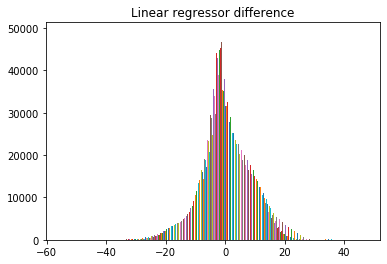

In [63]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [64]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [65]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

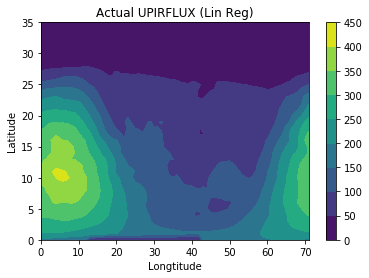

In [66]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

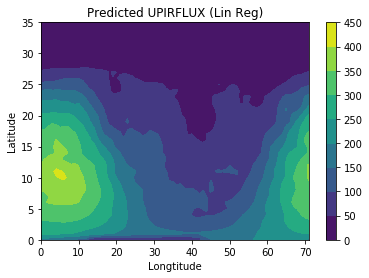

In [67]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

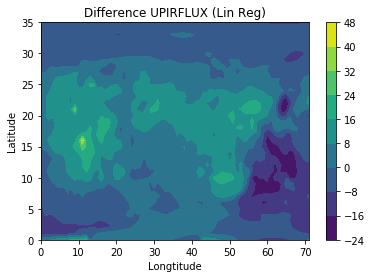

In [68]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

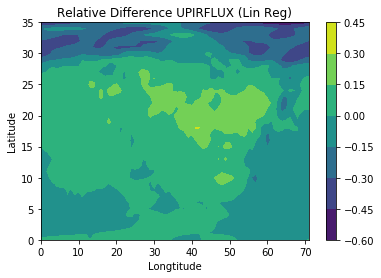

In [69]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [70]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [71]:
real_out.shape

(36, 72)

In [72]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [73]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[3.40012071, 2.97138564, 3.22418481, ..., 2.23075457, 2.6477122 ,
        2.53098237],
       [3.40012868, 2.97137604, 3.22419123, ..., 2.23077006, 2.64772453,
        2.53097374],
       [3.39980488, 2.97105863, 3.22386982, ..., 2.23042107, 2.6473975 ,
        2.53064954],
       ...,
       [5.96823557, 4.63512534, 5.26359773, ..., 3.58878064, 4.34373606,
        3.36525572],
       [5.97486141, 4.60587019, 5.24524163, ..., 3.59485019, 4.36069654,
        3.34749933],
       [5.97815535, 4.55006515, 5.20961646, ..., 3.59982559, 4.37954567,
        3.31144299]])

In [74]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([3.49531015, 3.49532266, 3.49499653, 3.49514382, 3.49496027,
       3.49505067, 3.49457972, 3.49527486, 3.49493796, 3.49432092,
       3.49453718, 3.49517074, 3.49574113, 3.49624436, 3.4976174 ,
       3.50093206, 3.50617242, 3.51206684, 3.51812268, 3.52528861,
       3.53606126, 3.5514825 , 3.57241324, 3.60122944, 3.63546276,
       3.67888674, 3.72771429, 3.80638728, 3.90574732, 4.0240057 ,
       4.16559886, 4.33032414, 4.50481164, 4.69162741, 4.88621274,
       5.08536188, 5.28941522, 5.49410628, 5.65414747, 5.71208365,
       5.76915474, 5.80233654, 5.83591121, 5.87028725, 5.90200562,
       5.92018405, 5.93634677, 5.95077834, 5.96006063, 5.96823557,
       5.97486141, 5.97815535])

In [75]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([2.21209137, 2.21212418, 2.21176728, 2.21200767, 2.21155097,
       2.21150702, 2.21065359, 2.21120419, 2.21115608, 2.21061475,
       2.21064945, 2.21079888, 2.21117749, 2.21205216, 2.21385959,
       2.21697168, 2.22143907, 2.22745922, 2.23551705, 2.24612096,
       2.26018185, 2.27666899, 2.2963031 , 2.32300944, 2.35469988,
       2.39388515, 2.42920965, 2.47496251, 2.53088498, 2.59600183,
       2.67111409, 2.76165943, 2.8557949 , 2.95170457, 3.05105543,
       3.15562716, 3.26747751, 3.35462056, 3.38023945, 3.38624226,
       3.38970201, 3.38975169, 3.38866394, 3.38858938, 3.38836422,
       3.38640599, 3.38422216, 3.38300584, 3.3762633 , 3.36525572,
       3.34749933, 3.31144299])

In [76]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.31017357, 0.31017295, 0.31017965, 0.31018083, 0.31024185,
       0.31028484, 0.3103376 , 0.31038782, 0.31036059, 0.31030914,
       0.31025252, 0.31019216, 0.31017054, 0.31022651, 0.31036   ,
       0.31054642, 0.31080945, 0.31103481, 0.3110247 , 0.31086122,
       0.31081526, 0.31124665, 0.31251702, 0.31481421, 0.31816491,
       0.32276251, 0.3278601 , 0.33327008, 0.33976117, 0.34838301,
       0.35943247, 0.3717888 , 0.38582003, 0.40345404, 0.42297902,
       0.44312761, 0.46581017, 0.49320824, 0.51682273, 0.52655584,
       0.53720597, 0.54398586, 0.55117407, 0.55831891, 0.56490421,
       0.56901957, 0.57272402, 0.57602352, 0.57993386, 0.58481669,
       0.59074287, 0.60040372])

In [77]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([2.81663461, 2.81664012, 2.81630746, 2.81648341, 2.81615274,
       2.81612898, 2.81552825, 2.81635189, 2.81616909, 2.81547651,
       2.81537682, 2.81524886, 2.81531186, 2.81604952, 2.81788169,
       2.82092833, 2.82521785, 2.83082241, 2.83820605, 2.8479684 ,
       2.86171411, 2.88028057, 2.90393968, 2.93503482, 2.97144296,
       3.01656669, 3.06841681, 3.13181175, 3.20676194, 3.29429701,
       3.39641791, 3.51525114, 3.64056637, 3.77193343, 3.90501607,
       4.03810787, 4.17091685, 4.29482572, 4.38471437, 4.41455804,
       4.44138835, 4.45495763, 4.46740126, 4.47991813, 4.49039287,
       4.49510613, 4.49928995, 4.50428447, 4.50486596, 4.50268165,
       4.49652662, 4.48002622])

In [78]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
3.4620057351443227


# Predicting Spring:

In [79]:
uif_lin = lr1.predict(sla_spring)
uif_out = uif_spring

In [80]:
lr1.coef_

array([[ 3.41186990e-08,  3.08322718e-08, -1.59478830e-08, ...,
         8.24838992e-07, -1.06795346e-06,  4.91201172e-06],
       [ 3.41186848e-08,  3.08322754e-08, -1.59476929e-08, ...,
         8.24828476e-07, -1.06795949e-06,  4.91196442e-06],
       [ 3.41186848e-08,  3.08322541e-08, -1.59477747e-08, ...,
         8.24823644e-07, -1.06796324e-06,  4.91191167e-06],
       ...,
       [ 3.94447106e-08,  3.03319965e-08, -1.38455603e-08, ...,
         6.11371263e-07, -6.48868081e-07,  2.01844932e-06],
       [ 3.97125675e-08,  3.08772350e-08, -1.39729819e-08, ...,
         6.13629254e-07, -6.49445838e-07,  1.96423071e-06],
       [ 4.00819644e-08,  3.17593845e-08, -1.38405465e-08, ...,
         6.18893296e-07, -6.51899086e-07,  1.89722937e-06]], dtype=float32)

In [81]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

6.2019715

In [82]:
np.min(uif_out)

15.936197

In [83]:
np.max(uif_out)

414.86307

In [84]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

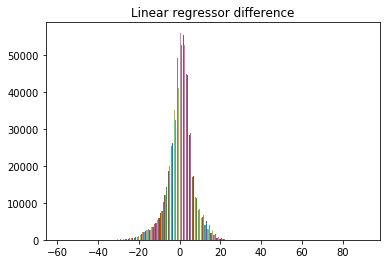

In [85]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [86]:
uif_out.reshape(-1,1).shape

(21430656, 1)

In [87]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

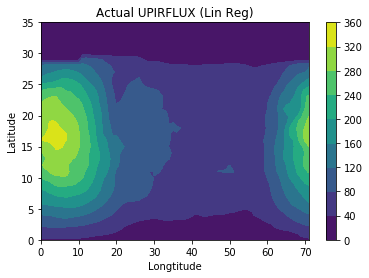

In [88]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

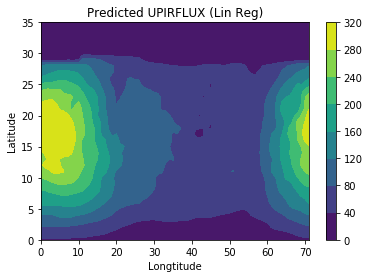

In [89]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

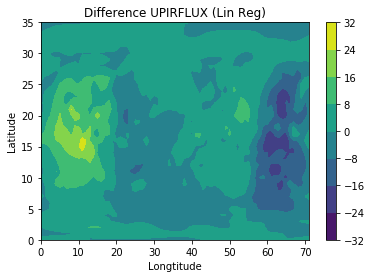

In [90]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

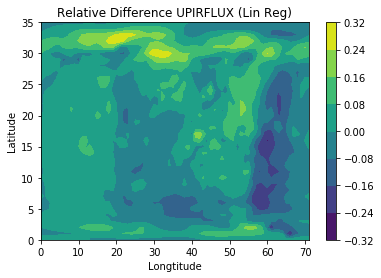

In [91]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [92]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [93]:
real_out.shape

(36, 72)

In [94]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [95]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.2007005 ,  0.04246816,  0.36691802, ..., -0.10117024,
         0.35178383,  0.26280153],
       [ 0.20074584,  0.04252754,  0.3669772 , ..., -0.10111245,
         0.35184184,  0.26283923],
       [ 0.20043735,  0.04221345,  0.36665431, ..., -0.10144089,
         0.35152063,  0.26253697],
       ...,
       [-0.04406821, -0.71493278,  0.13228634, ..., -0.39281577,
         0.20429896, -0.37128007],
       [-0.01334051, -0.7193548 ,  0.14810941, ..., -0.37476813,
         0.23123094, -0.37391078],
       [ 0.02834649, -0.72611568,  0.16989371, ..., -0.34300699,
         0.27219731, -0.37666991]])

In [96]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.72772698, 0.72777668, 0.72745085, 0.72796175, 0.72761897,
       0.72783385, 0.72760615, 0.72839356, 0.72820716, 0.72767243,
       0.72784141, 0.72784456, 0.7276763 , 0.72739687, 0.72684448,
       0.7259673 , 0.7239747 , 0.72074241, 0.71700952, 0.71346105,
       0.71200492, 0.71287096, 0.71408305, 0.71393553, 0.708848  ,
       0.7000626 , 0.68527126, 0.66946469, 0.651177  , 0.62817972,
       0.60032346, 0.5758395 , 0.55065431, 0.52320225, 0.50835504,
       0.48930932, 0.46527479, 0.44630591, 0.44590982, 0.45024967,
       0.46114594, 0.46837451, 0.47659412, 0.48826797, 0.50225792,
       0.51135376, 0.52240995, 0.53919378, 0.55868824, 0.58511634,
       0.62164712, 0.67071175])

In [97]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.12078263, -0.1207175 , -0.12105296, -0.12055247, -0.12074104,
       -0.12060634, -0.12126885, -0.1208931 , -0.12092391, -0.12117967,
       -0.12095115, -0.12124292, -0.12152359, -0.12171941, -0.12204074,
       -0.12274467, -0.12444719, -0.12723142, -0.13059106, -0.13378114,
       -0.1348761 , -0.13385773, -0.13322082, -0.13464996, -0.14104961,
       -0.15127599, -0.16773325, -0.18500681, -0.20470148, -0.22887346,
       -0.25929734, -0.28895726, -0.31956985, -0.34994808, -0.37745929,
       -0.4110271 , -0.48986002, -0.56746571, -0.61899201, -0.63660635,
       -0.6530475 , -0.66298623, -0.67329473, -0.68171588, -0.68943462,
       -0.69557355, -0.70067382, -0.70319049, -0.70902593, -0.71493278,
       -0.7193548 , -0.72611568])

In [98]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.21550708, 0.21550643, 0.21550886, 0.21552892, 0.21554018,
       0.21557124, 0.21564744, 0.21567605, 0.2155228 , 0.21542156,
       0.21546355, 0.21556085, 0.21560776, 0.21559337, 0.21558073,
       0.21560002, 0.21560558, 0.21562155, 0.2157364 , 0.21593064,
       0.21618982, 0.21656983, 0.21718198, 0.21794498, 0.2188016 ,
       0.2198405 , 0.22108307, 0.22238762, 0.22395144, 0.22609896,
       0.22911965, 0.23246185, 0.23532686, 0.23908716, 0.24392933,
       0.24907052, 0.25682846, 0.26900186, 0.28239667, 0.28843549,
       0.2945782 , 0.29831822, 0.30234395, 0.30667102, 0.31141253,
       0.31491381, 0.31871101, 0.32313323, 0.32865117, 0.3350343 ,
       0.34241709, 0.35257085])

In [99]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([ 0.30411652,  0.30417021,  0.30385027,  0.30438435,  0.3041345 ,
        0.30432459,  0.30386305,  0.30440696,  0.30410128,  0.30358272,
        0.30382882,  0.30372604,  0.30352228,  0.30334342,  0.30301898,
        0.30238032,  0.30067118,  0.29767462,  0.29398389,  0.29026165,
        0.28848206,  0.28899506,  0.28994269,  0.28951159,  0.28411461,
        0.27501271,  0.25984417,  0.24326569,  0.22390554,  0.19977716,
        0.17034318,  0.14192673,  0.11127752,  0.08026184,  0.05001199,
        0.01234647, -0.02635158, -0.05918885, -0.07387524, -0.07601091,
       -0.07620087, -0.07619763, -0.07598252, -0.07334337, -0.06937824,
       -0.06699604, -0.06290313, -0.05526926, -0.04842744, -0.0381495 ,
       -0.02142737,  0.00323675])

In [100]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.1606903741035327


# Last test set:

In [124]:
uif_lin = lr1.predict(sla_test_set)
uif_out = uif_test_set

In [125]:
lr1.coef_

array([[ 3.41186990e-08,  3.08322718e-08, -1.59478830e-08, ...,
         8.24838992e-07, -1.06795346e-06,  4.91201172e-06],
       [ 3.41186848e-08,  3.08322754e-08, -1.59476929e-08, ...,
         8.24828476e-07, -1.06795949e-06,  4.91196442e-06],
       [ 3.41186848e-08,  3.08322541e-08, -1.59477747e-08, ...,
         8.24823644e-07, -1.06796324e-06,  4.91191167e-06],
       ...,
       [ 3.94447106e-08,  3.03319965e-08, -1.38455603e-08, ...,
         6.11371263e-07, -6.48868081e-07,  2.01844932e-06],
       [ 3.97125675e-08,  3.08772350e-08, -1.39729819e-08, ...,
         6.13629254e-07, -6.49445838e-07,  1.96423071e-06],
       [ 4.00819644e-08,  3.17593845e-08, -1.38405465e-08, ...,
         6.18893296e-07, -6.51899086e-07,  1.89722937e-06]], dtype=float32)

In [126]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

11.320609

In [127]:
np.min(uif_out)

16.084946

In [128]:
np.max(uif_out)

489.8716

In [129]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

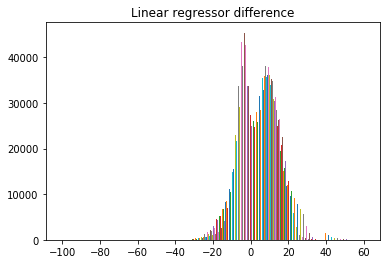

In [130]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [131]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [132]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

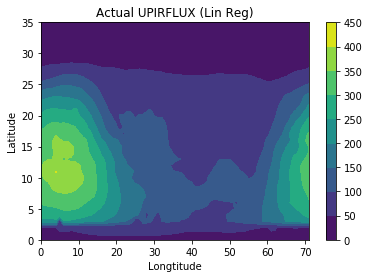

In [133]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

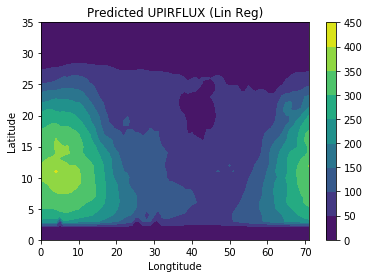

In [134]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

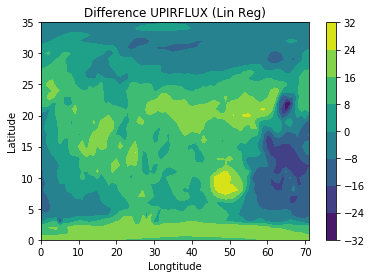

In [135]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

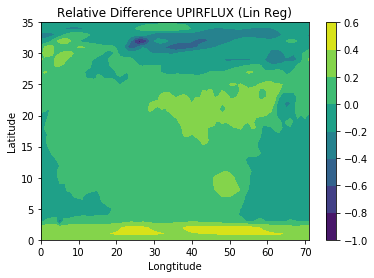

In [136]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [137]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [138]:
real_out.shape

(36, 72)

In [139]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [140]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[5.17507566, 4.78758545, 5.19869775, ..., 5.2885442 , 5.60740051,
        5.5217688 ],
       [5.17508781, 4.78758063, 5.1987083 , ..., 5.2885355 , 5.6073692 ,
        5.52174896],
       [5.17477311, 4.78723782, 5.19837547, ..., 5.28818638, 5.60704367,
        5.52140788],
       ...,
       [8.87793605, 7.55041875, 8.69626281, ..., 8.73224924, 9.67774374,
        8.64902726],
       [8.79176865, 7.43343396, 8.59647258, ..., 8.67390711, 9.63837225,
        8.5722939 ],
       [8.67586003, 7.26676675, 8.469201  , ..., 8.58974549, 9.57285054,
        8.45084998]])

In [141]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 6.30973271,  6.30973968,  6.30939023,  6.30951093,  6.30923269,
        6.30934808,  6.30877028,  6.30964596,  6.30936309,  6.30894713,
        6.30943132,  6.31058743,  6.31193464,  6.31443254,  6.31907836,
        6.32702426,  6.33802944,  6.35057381,  6.36284211,  6.37822258,
        6.40109469,  6.43338967,  6.47937553,  6.54593552,  6.63112482,
        6.74171606,  6.87657441,  7.03952412,  7.23186608,  7.45958213,
        7.7267655 ,  8.02268319,  8.33081838,  8.65575752,  8.98991051,
        9.324974  ,  9.65223797,  9.95778549, 10.15813236, 10.21720692,
       10.26553859, 10.28798637, 10.309818  , 10.32502087, 10.32867782,
       10.32272538, 10.30981751, 10.28961433, 10.25644115, 10.21101918,
       10.14972239, 10.06109388])

In [142]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.78758545, 4.78758063, 4.78723782, 4.78722396, 4.78664184,
       4.78678901, 4.78649807, 4.78751296, 4.78717326, 4.78661174,
       4.7869736 , 4.78762855, 4.78839244, 4.79035516, 4.79420357,
       4.8002097 , 4.80831335, 4.81952191, 4.8356679 , 4.85681083,
       4.88208152, 4.91336999, 4.9555175 , 5.01546425, 5.09231899,
       5.19260978, 5.3170103 , 5.46482478, 5.63349725, 5.83040505,
       6.06428472, 6.324633  , 6.59461745, 6.87304373, 7.15301113,
       7.43240149, 7.68298472, 7.86929172, 7.95140815, 7.95973997,
       7.95185708, 7.93738125, 7.91500242, 7.88365743, 7.84067394,
       7.80346232, 7.75927028, 7.70732319, 7.63882075, 7.55041875,
       7.43343396, 7.26676675])

In [143]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.33036105, 0.33035902, 0.33035732, 0.33035492, 0.33039023,
       0.33038327, 0.33036836, 0.33037745, 0.3304191 , 0.33048493,
       0.33057726, 0.33069006, 0.33075687, 0.33071496, 0.33061581,
       0.33085448, 0.3315663 , 0.33227155, 0.33228786, 0.33185768,
       0.33172217, 0.33213306, 0.33295144, 0.33428626, 0.33620375,
       0.33892968, 0.34219773, 0.34600654, 0.35081226, 0.35722506,
       0.36526029, 0.37438663, 0.38450584, 0.39758634, 0.41366798,
       0.43122989, 0.45279695, 0.48266653, 0.51275515, 0.52644373,
       0.54205947, 0.55238854, 0.56346923, 0.57473737, 0.58546226,
       0.59228295, 0.59892255, 0.60580223, 0.61400927, 0.62423118,
       0.6370432 , 0.65568874])

In [144]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.49830199, 5.49829326, 5.49795068, 5.4980407 , 5.49764126,
       5.49764575, 5.49705646, 5.49799244, 5.49777125, 5.4972272 ,
       5.49730882, 5.49776259, 5.49881222, 5.50158016, 5.50646982,
       5.51358397, 5.52274496, 5.53409612, 5.54791041, 5.56546107,
       5.5892682 , 5.62173629, 5.66696898, 5.73166561, 5.81428102,
       5.92060658, 6.0505542 , 6.20759417, 6.39124752, 6.60699398,
       6.86146806, 7.1455214 , 7.44137303, 7.75037241, 8.06589475,
       8.38616794, 8.68919866, 8.94627613, 9.10005952, 9.14053611,
       9.16815227, 9.17648698, 9.17853012, 9.172762  , 9.1553208 ,
       9.13517958, 9.10859188, 9.07571632, 9.02915262, 8.96729426,
       8.88548497, 8.77006976])

In [145]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
6.925272639371691


Large